In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
import zipfile
import wget
from datetime import date, timedelta, datetime
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from PIL import Image
from scipy import stats
from xgboost import XGBRegressor

In [22]:
file_wildfires         = "Nov_10/Historical_Wildfires.csv"
file_weather           = "Nov_10/HistoricalWeather.csv"
file_weatherforecast   = "Nov_10/HistoricalWeatherForecasts.csv"
file_landclass         = "Nov_10/LandClass.csv"
file_vegetation        = "Nov_10/VegetationIndex.csv"
file_weather_mani      = "Nov_10/weather_data_mani.csv"

# Load and prepare data

In [23]:
wt_df = pd.read_csv(file_weather_mani)
wt_df.head()

,Date,Region,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,RelativeHumidity_Variance,...,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
0,2005-01-01,NSW,1.836935,0.044274,0.000000,0.028362,80.522964,36.355567,13.877194,253.559937,...,14.515009,6.078587,35.878704,27.341182,14.485785,18.562212,7.670482,3.323550,1.354448,0.850048
1,2005-01-01,NT,315.266815,9.884958,0.000000,546.059262,95.683342,61.494675,14.558820,584.201131,...,2.518120,58.942658,38.136787,29.881492,24.179960,12.920252,9.704402,5.296892,1.840394,1.930014
2,2005-01-01,QL,74.452164,1.453053,0.000000,35.641257,95.898270,47.959364,14.443199,403.134377,...,6.033827,29.500832,37.047943,28.842866,20.951620,13.792599,7.675632,3.483753,1.106028,0.883048
3,2005-01-01,SA,3.193624,0.059078,0.000000,0.042837,81.980751,30.057683,10.618136,246.044713,...,17.861103,7.914246,38.326847,30.793675,14.095855,34.799336,10.044715,4.657538,2.023657,1.655908
4,2005-01-01,TA,13.604791,3.099497,0.003973,12.068597,81.501442,65.086764,43.906574,111.754034,...,20.742302,12.826400,16.228510,11.788805,6.686816,4.912013,11.432408,5.408138,1.995647,2.963118


In [24]:
wf_df = pd.read_csv(file_wildfires)
wf_df['Date'] = pd.to_datetime(wf_df['Date'])
wf_df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [25]:
def find_missing_date(df, start_date = (2005,1,1), end_date = (2020,10,31), 
                      region = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA'], 
                      date_col = 'Date') :
    
    df[date_col] = pd.to_datetime(df[date_col])
    start_date = date(start_date[0], start_date[1], start_date[2])
    end_date = date(end_date[0], end_date[1], end_date[2])
    total_date_set = set([start_date + timedelta(x) for x in range((end_date- start_date).days)])
    
    missing = dict()
    for reg in region : 
        df_temp = df[df['Region'] == reg]
        date_list = list(df_temp[date_col])
        date_set = set([ts.date() for ts in date_list])
        
        missing[reg] = total_date_set - date_set
        
    return missing

In [26]:
find_missing_date(wt_df)

{'NSW': set(),
 'NT': set(),
 'QL': set(),
 'SA': set(),
 'TA': set(),
 'VI': set(),
 'WA': set()}

In [27]:
for Reg in ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']:
    print(Reg+':'+str(len(find_missing_date(wf_df)[Reg])))

NSW:1160
NT:730
QL:250
SA:3792
TA:4378
VI:3606
WA:156


In [28]:
# Select only for NSW
wf_nsw = wf_df[wf_df['Region'] == 'NSW']
wt_nsw = wt_df[wt_df['Region'] == 'NSW']

In [29]:
data_nsw = wf_nsw[['Date', 'Estimated_fire_area']].merge(wt_nsw, how = 'left', on = 'Date')
data_nsw

,Date,Estimated_fire_area,Region,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,...,SolarRadiation_Min,SolarRadiation_Variance,Temperature_Max,Temperature_Mean,Temperature_Min,Temperature_Variance,WindSpeed_Max,WindSpeed_Mean,WindSpeed_Min,WindSpeed_Variance
0,2005-01-04,8.68000,NSW,22.842566,2.808620,0.0,17.383363,90.332771,57.095628,31.279930,...,7.576938,40.255460,28.945488,23.055527,12.495799,9.455474,7.364222,4.841764,1.401951,1.494301
1,2005-01-05,16.61125,NSW,7.657155,0.157935,0.0,0.273471,88.623436,47.170735,24.466665,...,14.087289,29.763055,29.510120,22.425765,9.611800,13.352380,7.091141,4.014080,1.011328,1.043316
2,2005-01-06,5.52000,NSW,27.616505,0.434833,0.0,4.634465,92.850960,39.874638,21.705952,...,12.310518,22.667707,26.982698,20.621405,9.024039,11.764178,9.905821,4.477879,0.930842,1.953685
3,2005-01-07,6.26400,NSW,3.839235,0.064224,0.0,0.038927,79.103134,39.279410,16.215517,...,16.044561,6.949267,24.752069,19.632722,8.691216,7.940373,10.446799,4.017578,1.601724,1.102751
4,2005-01-08,5.40000,NSW,2.866673,0.203352,0.0,0.236269,83.001541,42.400824,14.008522,...,15.209880,27.822830,26.472469,21.477315,10.821342,12.063971,6.671862,3.884550,1.167861,0.774612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,2020-10-25,3.00000,NSW,66.635353,5.620920,0.0,54.916094,99.538780,68.805714,34.010914,...,2.952551,59.706485,22.742195,14.048608,4.655551,6.921498,10.609229,4.180923,1.107591,1.977909
4619,2020-10-27,1.21000,NSW,58.436600,2.124025,0.0,19.255058,97.393547,65.191496,17.911118,...,8.514027,23.311615,22.218430,16.707067,7.288919,8.529138,5.497386,3.043550,1.036175,0.613602
4620,2020-10-28,3.00000,NSW,30.506205,4.350241,0.0,33.377184,93.729408,65.642208,20.347416,...,9.952868,12.846223,22.422768,16.916040,8.654533,7.148141,4.353423,2.551310,0.790777,0.562205
4621,2020-10-30,1.32000,NSW,46.937473,6.023114,0.0,48.708134,89.295311,65.992435,23.371044,...,8.277431,17.436028,24.310499,17.367429,10.133630,6.171237,8.527669,4.623190,1.465277,2.912816


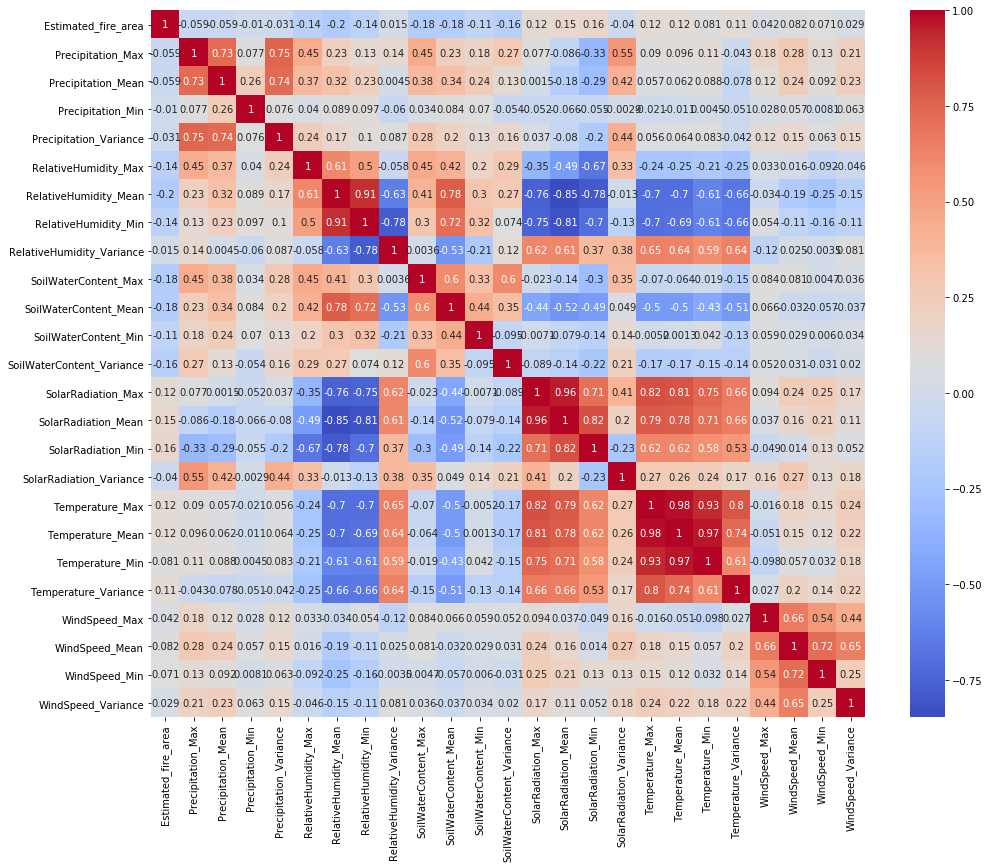

In [30]:
fig, ax = plt.subplots(figsize=(16,13))
sns.heatmap(data_nsw.corr(), cmap='coolwarm', annot=True)

In [31]:
# One-hot encoder month
data_nsw['month'] = data_nsw['Date'].dt.month
data_nsw_dummies = pd.get_dummies(data_nsw['month'])
data_nsw = data_nsw.join(data_nsw_dummies)

,Date,Estimated_fire_area,Region,Precipitation_Max,Precipitation_Mean,Precipitation_Min,Precipitation_Variance,RelativeHumidity_Max,RelativeHumidity_Mean,RelativeHumidity_Min,...,3,4,5,6,7,8,9,10,11,12
0,2005-01-04,8.68000,NSW,22.842566,2.808620,0.0,17.383363,90.332771,57.095628,31.279930,...,0,0,0,0,0,0,0,0,0,0
1,2005-01-05,16.61125,NSW,7.657155,0.157935,0.0,0.273471,88.623436,47.170735,24.466665,...,0,0,0,0,0,0,0,0,0,0
2,2005-01-06,5.52000,NSW,27.616505,0.434833,0.0,4.634465,92.850960,39.874638,21.705952,...,0,0,0,0,0,0,0,0,0,0
3,2005-01-07,6.26400,NSW,3.839235,0.064224,0.0,0.038927,79.103134,39.279410,16.215517,...,0,0,0,0,0,0,0,0,0,0
4,2005-01-08,5.40000,NSW,2.866673,0.203352,0.0,0.236269,83.001541,42.400824,14.008522,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4618,2020-10-25,3.00000,NSW,66.635353,5.620920,0.0,54.916094,99.538780,68.805714,34.010914,...,0,0,0,0,0,0,0,1,0,0
4619,2020-10-27,1.21000,NSW,58.436600,2.124025,0.0,19.255058,97.393547,65.191496,17.911118,...,0,0,0,0,0,0,0,1,0,0
4620,2020-10-28,3.00000,NSW,30.506205,4.350241,0.0,33.377184,93.729408,65.642208,20.347416,...,0,0,0,0,0,0,0,1,0,0
4621,2020-10-30,1.32000,NSW,46.937473,6.023114,0.0,48.708134,89.295311,65.992435,23.371044,...,0,0,0,0,0,0,0,1,0,0


In [39]:
X = data_nsw.drop(['Date', 'Estimated_fire_area', 'Region', 'month'], axis=1)
y = data_nsw['Estimated_fire_area']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [43]:
xgr = XGBRegressor()
xgr.fit(X_train, y_train)
preds = xgr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
Rsq = r2_score(y_test, preds)
print("RMSE: %f" % (rmse))
print("Rsq: %f" % (Rsq))

RMSE: 184.826132
Rsq: -0.435746


In [47]:
data_nsw['Estimated_fire_area_boxcox'], _ = stats.boxcox(data_nsw['Estimated_fire_area'])

In [49]:
X = data_nsw.drop(['Date', 'Estimated_fire_area','Estimated_fire_area_boxcox' , 'Region', 'month'], axis=1)
y = data_nsw['Estimated_fire_area_boxcox']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
xgr = XGBRegressor()
xgr.fit(X_train, y_train)
preds = xgr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
Rsq = r2_score(y_test, preds)
print("RMSE: %f" % (rmse))
print("Rsq: %f" % (Rsq))

RMSE: 0.972988
Rsq: 0.283938


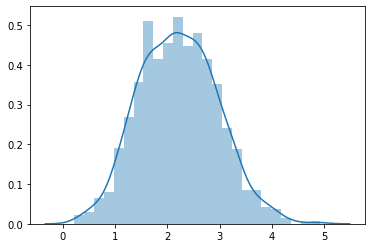

In [52]:
sns.distplot(preds)